In [1]:
import autograd.numpy as np
from autograd.numpy import linalg
from autograd.numpy.random import poisson, normal, multivariate_normal
from autograd import grad
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt

Defining Negative Poisson GP likelihood function in terms of observed counts $n_i$, mean model $y_i$, mean $\mu_i$, signal $s_i$, and GP kernel $\Sigma_{ij}$, we have the function:

$l(n_i, y_i | \mu_i, s_i, \Sigma_{ij}) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{y} - \vec{\mu})^T \Sigma^{-1} (\vec{y} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i)$

Split into terms:

$\begin{align*}
t1 &= -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} \text{(constants, Gaussian)}\\
t2 &= - \frac{1}{2} \left( (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) \text{(Gaussian)}\\
t3 &= \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) \text{(Poisson)}
\end{align*}$

In [54]:
def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    det = linalg.det(cov)
    t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = np.sum(ni * np.log(mu + s) - (mu + s))
    result =  t2 + t3 + t1
    if np.isnan(result)==True:
        #print ("IS NAN, t1: " + str(t1) + "\tt2: " + str(t2) + "\tt3: " + str(t3) + "\tsum: " + str(result))
        result = -np.infty
    #if t1-t2==t1 or t1-t3==t1:
       # result-=t1
    #print ("t1: " + str(t1) + "\tt2: " + str(t2) + "\tt3: " + str(t3) + "\tsum: " + str(result))
    return -result               
    
neg_log_like_PGP_grad = grad(neg_log_like_PGP)

Setting the models:


$\begin{align*}
\mu_{true, i} &= \frac{1}{ln(x_i+1)}\\
y_i(\theta_{y}) &= \frac{a}{(b*x_i+c)^2}+d, \theta_{y} = \{ a,b,c,d\}
\end{align*}$


In [3]:
def true_mu(x):
    return (1./np.log(.01*x+1))

def y_model(x):
    return 1./(np.power(x+.3,2))

def y_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def y_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return y_opt(x, params)
    
class mean_model(object):
    def __init__(self, f, params):
        self.f = f
        self.params = params
        self.frozen = True
    def get_value(self, x):
        return self.f(x, self.params)
    def freeze_all_parameters(self):
        self.frozen = True


def kernel_func_exp(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

def kernel_func_gibbs(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    l1 = (b * x1) + c
    l2 = (b * x2) + c
    lam = np.sqrt((2*l1*l2)/((l1**2)+(l2**2)))
    result = A * lam * np.exp(-(((x1-x2)**2)/((l1**2)+(l2**2)))+((d-(x1+x2))/(2.*a)))
    return result

#expkernel = ge.kernels.PythonKernel(kernel_func_exp, pars= [5., .5])

def make_kernel(x, k, params):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    return cov

def predict(t, n, y, cov, sigma):
    N = len(t)
    p_dist = np.empty(N)
    v_dist = np.empty(N)
    for i in range(N):
        inv = linalg.inv(cov+np.diag(np.power(sigma,2)))
        p_dist[i] = y[i] + cov[i].T.dot(inv.dot(n-y))
        v_dist[i] = cov[i][i] - cov[i].T.dot(inv.dot(cov[i]))
        if np.isnan(v_dist[i]):
            print ("NAN, cov diag = " + str(cov[i][i]) + "\t other term: " + str(cov[i].T.dot(inv.dot(cov[i]))))
    return p_dist, v_dist


In [44]:
#initializing true mu and storage arrays
N = 30
params_test = [25, 6., .3, 0.]
start = 2
stop = 20
scale = 2.5
t = np.linspace(start, stop,N) #2 - 20 for good pics
t_smooth = np.linspace(start, stop, 100)
mu_test =  scale * true_mu(t)
mu_test = mu_test - int(mu_test[-1:])
mu_smooth = scale * true_mu(t_smooth)
mu_smooth = mu_smooth - int(mu_smooth[-1:])
options={'ftol' :  np.finfo(float).eps, 'maxfun': 1.5e5, 'maxiter': 1.5e5, 'gtol': np.finfo(float).eps}

n_array = []
mu_GP_array = []
mu_PGP_array = []
y_array = []
'''
try:
    n_array
except NameError:
    print "Resetting n array"
    n_array = []
    
try:
    mu_GP_array
except NameError:
    print "Resetting GP array"
    mu_GP_array = []
    
try:
    mu_PGP_array
except NameError:
    print "Resetting PGP array"
    mu_PGP_array = []
    
try:
    y_array
except NameError:
    print "Resetting y array"
    y_array = []
'''

'\ntry:\n    n_array\nexcept NameError:\n    print "Resetting n array"\n    n_array = []\n    \ntry:\n    mu_GP_array\nexcept NameError:\n    print "Resetting GP array"\n    mu_GP_array = []\n    \ntry:\n    mu_PGP_array\nexcept NameError:\n    print "Resetting PGP array"\n    mu_PGP_array = []\n    \ntry:\n    y_array\nexcept NameError:\n    print "Resetting y array"\n    y_array = []\n'

\begin{align*}
\Sigma_{ij}(\theta_{\Sigma}) &= A \lambda e^{-\frac{(x_i-x_j)^2}{l(x_i)^2+l(x_j)^2}+\frac{d-(x_i+x_j)}{(2.*a))}}, l(x) = bx + c, \lambda = \sqrt{\frac{2l(x_i)l(x_j)}{l(x_i)^2+l(x_j)^2}}, \theta_{\Sigma} = \{A, a , b, c, d \}
\end{align*}

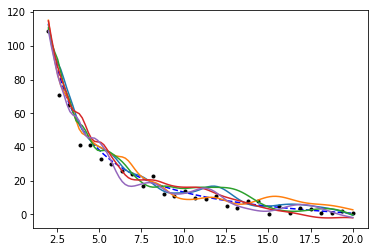

In [45]:
n_test = poisson(mu_test)
k_params = [10, 300., .1, 0., 100.]
cov_PGP_smooth = make_kernel(t_smooth, kernel_func_gibbs, k_params)
plt.plot(t_smooth, mu_smooth, 'b--', label = "True Mean")
plt.plot(t, n_test, 'k.', label = "counts")
for i in range(5):
    sample = np.random.multivariate_normal(mu_smooth, cov_PGP_smooth)
    plt.plot(t_smooth, sample)
    
plt.show()
#n_test = sample

In [46]:
    
#test run:
n_test = poisson(mu_test)
n_err = np.sqrt(n_test)
model_test = mu_test#y_opt(t, params_test)
s_test = np.zeros(N)
cov_PGP = make_kernel(t, kernel_func_gibbs, k_params)
boundarray = [(None,None) for i in range(N)]

pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(model_test))
pred_unc = np.sqrt(pred_var)

soln_PGP = minimize(neg_log_like_PGP, model_test,  method="L-BFGS-B", bounds = boundarray, args = (s_test, n_test, model_test, cov_PGP), options = options)
PGP_fit = soln_PGP.x
PGP_fit_unc = np.sqrt(np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
print soln_PGP
print (np.diag(cov_PGP)/np.sqrt(mu_test))
print n_test

t1: 403.1802703396226	t2: -0.0	t3: 1891.105361163675	sum: 2294.2856315032977
t1: 403.1802703396226	t2: -4.264184090977516e-18	t3: 1891.1053611645364	sum: 2294.285631504159
t1: 403.1802703396226	t2: -4.325823670061361e-18	t3: 1891.105361165631	sum: 2294.2856315052536
t1: 403.1802703396226	t2: -4.5768646354307584e-18	t3: 1891.1053611631594	sum: 2294.285631502782
t1: 403.1802703396226	t2: -5.237580939554461e-18	t3: 1891.105361165001	sum: 2294.285631504624
t1: 403.1802703396226	t2: -6.650554398641823e-18	t3: 1891.1053611652633	sum: 2294.2856315048857
t1: 403.1802703396226	t2: -9.533958643025592e-18	t3: 1891.1053611617338	sum: 2294.2856315013564
t1: 403.1802703396226	t2: -1.55975245932904e-17	t3: 1891.1053611624488	sum: 2294.2856315020713
t1: 403.1802703396226	t2: -2.91910949520442e-17	t3: 1891.1053611641673	sum: 2294.28563150379
t1: 403.1802703396226	t2: -6.211818997338434e-17	t3: 1891.1053611681816	sum: 2294.2856315078043
t1: 403.1802703396226	t2: -1.4846626303127364e-16	t3: 1891.10536116

t1: 403.1802703396226	t2: -0.006236780927051387	t3: 1891.1173353273723	sum: 2294.2913688860676
t1: 403.1802703396226	t2: -0.006236885208105077	t3: 1891.1173353341817	sum: 2294.291368788596
t1: 403.1802703396226	t2: -0.006236805633023931	t3: 1891.1173353241104	sum: 2294.2913688580998
t1: 403.1802703396226	t2: -0.006236819019271624	t3: 1891.1173353141007	sum: 2294.291368834704
t1: 403.1802703396226	t2: -0.006236848068334567	t3: 1891.1173353409806	sum: 2294.2913688325348
t1: 403.1802703396226	t2: -0.006236823295464194	t3: 1891.1173353281304	sum: 2294.2913688444573
t1: 403.1802703396226	t2: -0.00585872573852214	t3: 1891.117089942367	sum: 2294.291501556251
t1: 403.1802703396226	t2: -0.005858725738636755	t3: 1891.1170899432284	sum: 2294.2915015571125
t1: 403.1802703396226	t2: -0.005858725738802197	t3: 1891.1170899443234	sum: 2294.291501558207
t1: 403.1802703396226	t2: -0.0058587257384787005	t3: 1891.1170899418519	sum: 2294.291501555736
t1: 403.1802703396226	t2: -0.005858725738190507	t3: 1891

t1: 403.1802703396226	t2: -0.009054399058125474	t3: 1891.1235137546103	sum: 2294.2947296951747
t1: 403.1802703396226	t2: -0.009054443305893299	t3: 1891.1235137482638	sum: 2294.2947296445805
t1: 403.1802703396226	t2: -0.009054380560222442	t3: 1891.1235137559406	sum: 2294.294729715003
t1: 403.1802703396226	t2: -0.009054458986749545	t3: 1891.1235137627482	sum: 2294.294729643384
t1: 403.1802703396226	t2: -0.009054398162139434	t3: 1891.1235137526849	sum: 2294.294729694145
t1: 403.1802703396226	t2: -0.009054411698711958	t3: 1891.1235137426734	sum: 2294.294729670597
t1: 403.1802703396226	t2: -0.009054432099353766	t3: 1891.1235137695255	sum: 2294.2947296770485
t1: 403.1802703396226	t2: -0.009054412847730982	t3: 1891.1235137566848	sum: 2294.2947296834595
t1: 403.1802703396226	t2: -0.009331274553859856	t3: 1891.124384365584	sum: 2294.295323430653
t1: 403.1802703396226	t2: -0.009331274554085056	t3: 1891.1243843664454	sum: 2294.2953234315137
t1: 403.1802703396226	t2: -0.009331274554402599	t3: 1891

t1: 403.1802703396226	t2: -0.029521042089547648	t3: 1891.185181047508	sum: 2294.335930345041
t1: 403.1802703396226	t2: -0.029521042085794737	t3: 1891.1851810482228	sum: 2294.3359303457596
t1: 403.1802703396226	t2: -0.02952104212557948	t3: 1891.1851810499397	sum: 2294.3359303474367
t1: 403.1802703396226	t2: -0.029521041974934874	t3: 1891.1851810539472	sum: 2294.335930351595
t1: 403.1802703396226	t2: -0.02952104251341914	t3: 1891.18518104983	sum: 2294.335930346939
t1: 403.1802703396226	t2: -0.029521040922395745	t3: 1891.18518105228	sum: 2294.33593035098
t1: 403.1802703396226	t2: -0.02952104487362599	t3: 1891.1851810473038	sum: 2294.3359303420525
t1: 403.1802703396226	t2: -0.029521036582484502	t3: 1891.1851810523751	sum: 2294.3359303554153
t1: 403.1802703396226	t2: -0.029521050836463232	t3: 1891.1851810516926	sum: 2294.3359303404786
t1: 403.1802703396226	t2: -0.029521032242105668	t3: 1891.185181047203	sum: 2294.3359303545835
t1: 403.1802703396226	t2: -0.029521045890641456	t3: 1891.1851810

t1: 403.1802703396226	t2: -0.34130899204486875	t3: 1891.9143869672405	sum: 2294.753348314818
t1: 403.1802703396226	t2: -0.3413089697507504	t3: 1891.9143869734269	sum: 2294.7533483432985
t1: 403.1802703396226	t2: -0.3413090208468543	t3: 1891.91438696867	sum: 2294.7533482874455
t1: 403.1802703396226	t2: -0.34130893824004	t3: 1891.9143869790455	sum: 2294.753348380428
t1: 403.1802703396226	t2: -0.34130907170102454	t3: 1891.9143869738389	sum: 2294.7533482417602
t1: 403.1802703396226	t2: -0.34130885449101034	t3: 1891.9143869650177	sum: 2294.753348450149
t1: 403.1802703396226	t2: -0.3413091757326022	t3: 1891.9143869698853	sum: 2294.753348133775
t1: 403.1802703396226	t2: -0.34130877632597534	t3: 1891.9143869735506	sum: 2294.753348536847
t1: 403.1802703396226	t2: -0.34130917623289525	t3: 1891.9143869668678	sum: 2294.7533481302576
t1: 403.1802703396226	t2: -0.34130885903888236	t3: 1891.9143869740508	sum: 2294.7533484546343
t1: 403.1802703396226	t2: -0.341309051772064	t3: 1891.9143869807097	sum: 

t1: 403.1802703396226	t2: -0.48888210832748885	t3: 1892.112681852911	sum: 2294.804070084206
t1: 403.1802703396226	t2: -0.4888821037269799	t3: 1892.1126818546047	sum: 2294.8040700905003
t1: 403.1802703396226	t2: -0.48888211341975607	t3: 1892.1126818585078	sum: 2294.8040700847105
t1: 403.1802703396226	t2: -0.48888209550087103	t3: 1892.112681854494	sum: 2294.8040700986157
t1: 403.1802703396226	t2: -0.48888212510914913	t3: 1892.1126818568732	sum: 2294.804070071387
t1: 403.1802703396226	t2: -0.4888820815954489	t3: 1892.112681852022	sum: 2294.804070110049
t1: 403.1802703396226	t2: -0.4888821375143588	t3: 1892.1126818569323	sum: 2294.8040700590404
t1: 403.1802703396226	t2: -0.48888207331922984	t3: 1892.112681856289	sum: 2294.8040701225923
t1: 403.1802703396226	t2: -0.48888214512026	t3: 1892.112681851942	sum: 2294.8040700464444
t1: 403.1802703396226	t2: -0.4888820572170702	t3: 1892.1126818500027	sum: 2294.804070132408
t1: 403.1802703396226	t2: -0.4888821768456511	t3: 1892.1126818561847	sum: 22

t1: 403.1802703396226	t2: -0.4990066070894249	t3: 1892.4248039971592	sum: 2295.1060677296923
t1: 403.1802703396226	t2: -0.4990074214282002	t3: 1892.424804003631	sum: 2295.1060669218255
t1: 403.1802703396226	t2: -0.49900662035048987	t3: 1892.424803994518	sum: 2295.1060677137903
t1: 403.1802703396226	t2: -0.4990072404792238	t3: 1892.4248039848642	sum: 2295.1060670840075
t1: 403.1802703396226	t2: -0.4990068850640136	t3: 1892.4248040065343	sum: 2295.1060674610926
t1: 403.1802703396226	t2: -0.4990070217380079	t3: 1892.4248039927033	sum: 2295.106067310588
t1: 403.1802703396226	t2: -0.4833169116584512	t3: 1892.4109857840865	sum: 2295.1079392120505
t1: 403.1802703396226	t2: -0.4833169117000845	t3: 1892.4109857849428	sum: 2295.1079392128654
t1: 403.1802703396226	t2: -0.4833169117755796	t3: 1892.4109857860242	sum: 2295.1079392138713
t1: 403.1802703396226	t2: -0.48331691162242013	t3: 1892.4109857835758	sum: 2295.1079392115757
t1: 403.1802703396226	t2: -0.4833169116526769	t3: 1892.410985785394	sum

t1: 403.1802703396226	t2: -0.5340732468827387	t3: 1892.4664738562813	sum: 2295.112670949021
t1: 403.1802703396226	t2: -0.5340732410116146	t3: 1892.466473855585	sum: 2295.112670954196
t1: 403.1802703396226	t2: -0.5340732351861969	t3: 1892.4664738513652	sum: 2295.1126709558016
t1: 403.1802703396226	t2: -0.5340732313754011	t3: 1892.466473849422	sum: 2295.1126709576693
t1: 403.1802703396226	t2: -0.5340732788899429	t3: 1892.4664738555682	sum: 2295.112670916301
t1: 403.1802703396226	t2: -0.5340731553616807	t3: 1892.466473850746	sum: 2295.1126710350068
t1: 403.1802703396226	t2: -0.5340733773952069	t3: 1892.466473860822	sum: 2295.112670823049
t1: 403.1802703396226	t2: -0.5340730247620225	t3: 1892.466473855781	sum: 2295.1126711706415
t1: 403.1802703396226	t2: -0.5340735909972183	t3: 1892.466473847199	sum: 2295.1126705958245
t1: 403.1802703396226	t2: -0.5340726799021853	t3: 1892.4664738522956	sum: 2295.112671512016
t1: 403.1802703396226	t2: -0.534074043183119	t3: 1892.4664738558229	sum: 2295.112

t1: 403.1802703396226	t2: -0.5408535328498779	t3: 1892.4818945361121	sum: 2295.121311342885
t1: 403.1802703396226	t2: -0.5408534494988404	t3: 1892.4818945429722	sum: 2295.121311433096
t1: 403.1802703396226	t2: -0.540853524612323	t3: 1892.4818945494217	sum: 2295.1213113644317
t1: 403.1802703396226	t2: -0.540853494284281	t3: 1892.4818945403595	sum: 2295.121311385698
t1: 403.1802703396226	t2: -0.5408534765161206	t3: 1892.4818945307238	sum: 2295.12131139383
t1: 403.1802703396226	t2: -0.5408535034490863	t3: 1892.4818945521522	sum: 2295.1213113883255
t1: 403.1802703396226	t2: -0.5408534952246169	t3: 1892.4818945383854	sum: 2295.1213113827835
t1: 403.1802703396226	t2: -0.5416579474602545	t3: 1892.4817643807323	sum: 2295.120376772895
t1: 403.1802703396226	t2: -0.5416579475052643	t3: 1892.4817643815877	sum: 2295.120376773705
t1: 403.1802703396226	t2: -0.5416579475677654	t3: 1892.481764382669	sum: 2295.120376774724
t1: 403.1802703396226	t2: -0.5416579474087679	t3: 1892.481764380222	sum: 2295.120

t1: 403.1802703396226	t2: -0.5418037606277872	t3: 1892.4911464125194	sum: 2295.129612991514
t1: 403.1802703396226	t2: -0.5418037606726862	t3: 1892.4911464143354	sum: 2295.1296129932853
t1: 403.1802703396226	t2: -0.5418037610266699	t3: 1892.4911464145882	sum: 2295.1296129931843
t1: 403.1802703396226	t2: -0.5418037599491656	t3: 1892.4911464111183	sum: 2295.129612990792
t1: 403.1802703396226	t2: -0.541803762035833	t3: 1892.4911464118288	sum: 2295.1296129894154
t1: 403.1802703396226	t2: -0.5418037576428304	t3: 1892.4911464135052	sum: 2295.129612995485
t1: 403.1802703396226	t2: -0.5418037665758004	t3: 1892.491146417354	sum: 2295.129612990401
t1: 403.1802703396226	t2: -0.5418037514221989	t3: 1892.4911464133852	sum: 2295.1296130015858
t1: 403.1802703396226	t2: -0.5418037731059282	t3: 1892.4911464157549	sum: 2295.1296129822713
t1: 403.1802703396226	t2: -0.5418037483549965	t3: 1892.4911464109357	sum: 2295.1296130022033
t1: 403.1802703396226	t2: -0.5418037662977482	t3: 1892.4911464158101	sum: 22

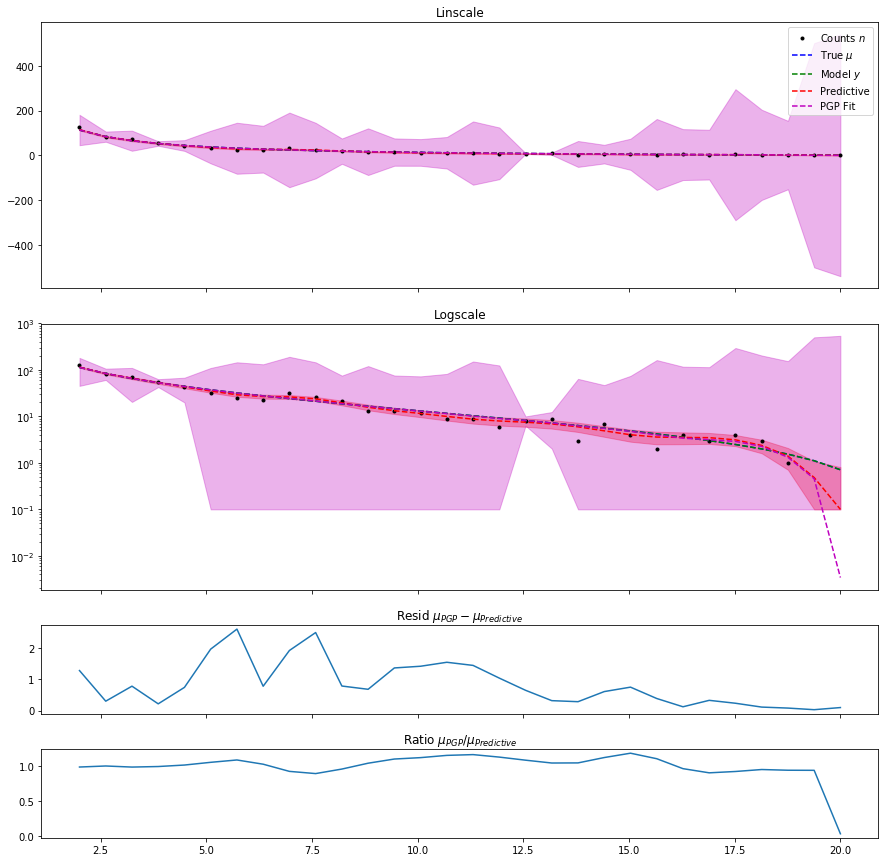

In [53]:
#test plot
from matplotlib import gridspec
PGP_low = PGP_fit-PGP_fit_unc
pred_low = pred-pred_unc
pred_safe = pred
pred_limit = pred
lowbound = 1e-1

sanitize = [PGP_low,pred_low, pred_limit]
for y in sanitize:
    for i in range(N):
        if y[i]<lowbound:
            y[i] = lowbound
   

#plotting results
PGP_fill = (PGP_fit + PGP_fit_unc, PGP_fit - PGP_fit_unc)
PGP_fill_log =  (PGP_fit + PGP_fit_unc, PGP_low)
pred_fill = (pred + pred_unc, pred - pred_unc)
pred_fill_log = (pred + pred_unc, pred_low)

plot = [n_test, mu_test, model_test, pred_limit, PGP_fit]
fmt = ['k.', 'b--', 'g--', 'r--', 'm--']
fill = [None, None, None, 'r',  'm']
labels = ["Counts $n$", "True $\mu$", "Model $y$", "Predictive", "PGP Fit"]
fill_bounds = [None, None, None, pred_fill,PGP_fill]
fill_bounds_log = [None, None, None, pred_fill_log, PGP_fill_log]



fig, ax = plt.subplots(nrows = 4, ncols = 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 1,1]}, figsize=(15,15))
for i in range(len(plot)):
    ax[0].plot(t, plot[i], fmt[i], label = labels[i])
    ax[1].set_yscale('log')
    ax[1].plot(t, plot[i], fmt[i], label = labels[i])
    if fill[i]!=None:
        ax[0].fill_between(t, fill_bounds[i][0], fill_bounds[i][1], color=fill[i], alpha=0.3, edgecolor='none')
        ax[1].fill_between(t, fill_bounds_log[i][0], fill_bounds_log[i][1], color=fill[i], alpha=0.3, edgecolor='none')

ax[2].plot(t, np.abs(PGP_fit-pred), label = "Residual")
ax[3].plot(t, np.abs(PGP_fit/pred), label = "Ratio")
#ax[4].plot(t, np.abs(PGP_fit/model_test), label = "Residual")
ax[0].legend(loc="upper right")

ax[0].set_title("Linscale")
ax[1].set_title("Logscale")
ax[2].set_title("Resid $\mu_{PGP} - \mu_{Predictive}$")
ax[3].set_title("Ratio $\mu_{PGP}/\mu_{Predictive}$")
#ax[4].set_title("Ratio $\mu_{PGP}/y_{model}$")

plt.show()

In [55]:
Nit = 3000
#sample NIt times
for k in range(Nit):
    n_test = poisson(mu_test)
    n_err = np.sqrt(n_test)
    n_array.append(n_test)
    
    model_test = mu_test
    y_array.append(model_test)
    s_test = np.zeros(N)

    cov_PGP = make_kernel(t, kernel_func_gibbs, k_params)
    
    #predictive analysis (gaussian)
    pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(model_test))
    pred_unc = np.sqrt(pred_var)
    mu_GP_array.append(pred)
    
    
    #PGP fit
    soln_PGP = minimize(neg_log_like_PGP, model_test, bounds = boundarray, method="L-BFGS-B", args = (s_test, n_test, model_test, cov_PGP), options = options)
    PGP_fit = soln_PGP.x
    PGP_fit_unc = np.sqrt(np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
    mu_PGP_array.append(PGP_fit)
    print(str((100.*(k+1))/Nit) + "% complete, Nit for optimization = " + str(soln_PGP.nit))
    

0.0333333333333% complete, Nit for optimization = 2595
0.0666666666667% complete, Nit for optimization = 59
0.1% complete, Nit for optimization = 35
0.133333333333% complete, Nit for optimization = 1343
0.166666666667% complete, Nit for optimization = 870
0.2% complete, Nit for optimization = 28
0.233333333333% complete, Nit for optimization = 3679
0.266666666667% complete, Nit for optimization = 3707
0.3% complete, Nit for optimization = 3732
0.333333333333% complete, Nit for optimization = 104
0.366666666667% complete, Nit for optimization = 54
0.4% complete, Nit for optimization = 67
0.433333333333% complete, Nit for optimization = 53
0.466666666667% complete, Nit for optimization = 89
0.5% complete, Nit for optimization = 104
0.533333333333% complete, Nit for optimization = 1058
0.566666666667% complete, Nit for optimization = 3831
0.6% complete, Nit for optimization = 55
0.633333333333% complete, Nit for optimization = 53
0.666666666667% complete, Nit for optimization = 40
0.7% co

5.66666666667% complete, Nit for optimization = 473
5.7% complete, Nit for optimization = 933
5.73333333333% complete, Nit for optimization = 38
5.76666666667% complete, Nit for optimization = 46
5.8% complete, Nit for optimization = 1029
5.83333333333% complete, Nit for optimization = 432
5.86666666667% complete, Nit for optimization = 3988
5.9% complete, Nit for optimization = 3740
5.93333333333% complete, Nit for optimization = 52
5.96666666667% complete, Nit for optimization = 140
6.0% complete, Nit for optimization = 489
6.03333333333% complete, Nit for optimization = 66
6.06666666667% complete, Nit for optimization = 65
6.1% complete, Nit for optimization = 893
6.13333333333% complete, Nit for optimization = 196
6.16666666667% complete, Nit for optimization = 57
6.2% complete, Nit for optimization = 2448
6.23333333333% complete, Nit for optimization = 143
6.26666666667% complete, Nit for optimization = 3790
6.3% complete, Nit for optimization = 3643
6.33333333333% complete, Nit f

11.3% complete, Nit for optimization = 328
11.3333333333% complete, Nit for optimization = 3981
11.3666666667% complete, Nit for optimization = 32
11.4% complete, Nit for optimization = 3724
11.4333333333% complete, Nit for optimization = 393
11.4666666667% complete, Nit for optimization = 321
11.5% complete, Nit for optimization = 195
11.5333333333% complete, Nit for optimization = 93
11.5666666667% complete, Nit for optimization = 237
11.6% complete, Nit for optimization = 48
11.6333333333% complete, Nit for optimization = 84
11.6666666667% complete, Nit for optimization = 90
11.7% complete, Nit for optimization = 408
11.7333333333% complete, Nit for optimization = 2323
11.7666666667% complete, Nit for optimization = 144
11.8% complete, Nit for optimization = 123
11.8333333333% complete, Nit for optimization = 306
11.8666666667% complete, Nit for optimization = 27
11.9% complete, Nit for optimization = 127
11.9333333333% complete, Nit for optimization = 12
11.9666666667% complete, Ni

16.9% complete, Nit for optimization = 3454
16.9333333333% complete, Nit for optimization = 97
16.9666666667% complete, Nit for optimization = 76
17.0% complete, Nit for optimization = 112
17.0333333333% complete, Nit for optimization = 236
17.0666666667% complete, Nit for optimization = 1423
17.1% complete, Nit for optimization = 98
17.1333333333% complete, Nit for optimization = 101
17.1666666667% complete, Nit for optimization = 3895
17.2% complete, Nit for optimization = 563
17.2333333333% complete, Nit for optimization = 3866
17.2666666667% complete, Nit for optimization = 2555
17.3% complete, Nit for optimization = 87
17.3333333333% complete, Nit for optimization = 119
17.3666666667% complete, Nit for optimization = 154
17.4% complete, Nit for optimization = 3607
17.4333333333% complete, Nit for optimization = 579
17.4666666667% complete, Nit for optimization = 55
17.5% complete, Nit for optimization = 74
17.5333333333% complete, Nit for optimization = 757
17.5666666667% complete

22.5% complete, Nit for optimization = 1043
22.5333333333% complete, Nit for optimization = 3549
22.5666666667% complete, Nit for optimization = 112
22.6% complete, Nit for optimization = 109
22.6333333333% complete, Nit for optimization = 2367
22.6666666667% complete, Nit for optimization = 85
22.7% complete, Nit for optimization = 34
22.7333333333% complete, Nit for optimization = 130
22.7666666667% complete, Nit for optimization = 2109
22.8% complete, Nit for optimization = 3661
22.8333333333% complete, Nit for optimization = 123
22.8666666667% complete, Nit for optimization = 2551
22.9% complete, Nit for optimization = 3601
22.9333333333% complete, Nit for optimization = 3965
22.9666666667% complete, Nit for optimization = 3926
23.0% complete, Nit for optimization = 479
23.0333333333% complete, Nit for optimization = 368
23.0666666667% complete, Nit for optimization = 72
23.1% complete, Nit for optimization = 3935
23.1333333333% complete, Nit for optimization = 1188
23.1666666667% 

28.0666666667% complete, Nit for optimization = 152
28.1% complete, Nit for optimization = 2542
28.1333333333% complete, Nit for optimization = 69
28.1666666667% complete, Nit for optimization = 25
28.2% complete, Nit for optimization = 597
28.2333333333% complete, Nit for optimization = 202
28.2666666667% complete, Nit for optimization = 3877
28.3% complete, Nit for optimization = 117
28.3333333333% complete, Nit for optimization = 53
28.3666666667% complete, Nit for optimization = 3847
28.4% complete, Nit for optimization = 41
28.4333333333% complete, Nit for optimization = 3788
28.4666666667% complete, Nit for optimization = 409
28.5% complete, Nit for optimization = 45
28.5333333333% complete, Nit for optimization = 24
28.5666666667% complete, Nit for optimization = 104
28.6% complete, Nit for optimization = 3350
28.6333333333% complete, Nit for optimization = 3745
28.6666666667% complete, Nit for optimization = 441
28.7% complete, Nit for optimization = 3691
28.7333333333% complet

33.6666666667% complete, Nit for optimization = 102
33.7% complete, Nit for optimization = 1798
33.7333333333% complete, Nit for optimization = 3864
33.7666666667% complete, Nit for optimization = 3689
33.8% complete, Nit for optimization = 907
33.8333333333% complete, Nit for optimization = 1280
33.8666666667% complete, Nit for optimization = 4029
33.9% complete, Nit for optimization = 3777
33.9333333333% complete, Nit for optimization = 54
33.9666666667% complete, Nit for optimization = 3783
34.0% complete, Nit for optimization = 152
34.0333333333% complete, Nit for optimization = 298
34.0666666667% complete, Nit for optimization = 1725
34.1% complete, Nit for optimization = 136
34.1333333333% complete, Nit for optimization = 2128
34.1666666667% complete, Nit for optimization = 2913
34.2% complete, Nit for optimization = 1623
34.2333333333% complete, Nit for optimization = 232
34.2666666667% complete, Nit for optimization = 66
34.3% complete, Nit for optimization = 77
34.3333333333% 

39.2666666667% complete, Nit for optimization = 2903
39.3% complete, Nit for optimization = 1252
39.3333333333% complete, Nit for optimization = 3577
39.3666666667% complete, Nit for optimization = 502
39.4% complete, Nit for optimization = 572
39.4333333333% complete, Nit for optimization = 3788
39.4666666667% complete, Nit for optimization = 81
39.5% complete, Nit for optimization = 75
39.5333333333% complete, Nit for optimization = 61
39.5666666667% complete, Nit for optimization = 726
39.6% complete, Nit for optimization = 54
39.6333333333% complete, Nit for optimization = 654
39.6666666667% complete, Nit for optimization = 80
39.7% complete, Nit for optimization = 55
39.7333333333% complete, Nit for optimization = 101
39.7666666667% complete, Nit for optimization = 881
39.8% complete, Nit for optimization = 83
39.8333333333% complete, Nit for optimization = 3804
39.8666666667% complete, Nit for optimization = 2159
39.9% complete, Nit for optimization = 808
39.9333333333% complete,

44.8666666667% complete, Nit for optimization = 205
44.9% complete, Nit for optimization = 1465
44.9333333333% complete, Nit for optimization = 3710
44.9666666667% complete, Nit for optimization = 714
45.0% complete, Nit for optimization = 731
45.0333333333% complete, Nit for optimization = 81
45.0666666667% complete, Nit for optimization = 39
45.1% complete, Nit for optimization = 2798
45.1333333333% complete, Nit for optimization = 3285
45.1666666667% complete, Nit for optimization = 743
45.2% complete, Nit for optimization = 59
45.2333333333% complete, Nit for optimization = 584
45.2666666667% complete, Nit for optimization = 834
45.3% complete, Nit for optimization = 3434
45.3333333333% complete, Nit for optimization = 2052
45.3666666667% complete, Nit for optimization = 3202
45.4% complete, Nit for optimization = 82
45.4333333333% complete, Nit for optimization = 3771
45.4666666667% complete, Nit for optimization = 3579
45.5% complete, Nit for optimization = 3786
45.5333333333% co

50.4666666667% complete, Nit for optimization = 141
50.5% complete, Nit for optimization = 244
50.5333333333% complete, Nit for optimization = 119
50.5666666667% complete, Nit for optimization = 61
50.6% complete, Nit for optimization = 71
50.6333333333% complete, Nit for optimization = 4026
50.6666666667% complete, Nit for optimization = 31
50.7% complete, Nit for optimization = 70
50.7333333333% complete, Nit for optimization = 97
50.7666666667% complete, Nit for optimization = 353
50.8% complete, Nit for optimization = 289
50.8333333333% complete, Nit for optimization = 1974
50.8666666667% complete, Nit for optimization = 75
50.9% complete, Nit for optimization = 155
50.9333333333% complete, Nit for optimization = 148
50.9666666667% complete, Nit for optimization = 43
51.0% complete, Nit for optimization = 3734
51.0333333333% complete, Nit for optimization = 3949
51.0666666667% complete, Nit for optimization = 45
51.1% complete, Nit for optimization = 967
51.1333333333% complete, Ni

56.0666666667% complete, Nit for optimization = 175
56.1% complete, Nit for optimization = 342
56.1333333333% complete, Nit for optimization = 765
56.1666666667% complete, Nit for optimization = 3367
56.2% complete, Nit for optimization = 437
56.2333333333% complete, Nit for optimization = 618
56.2666666667% complete, Nit for optimization = 3818
56.3% complete, Nit for optimization = 89
56.3333333333% complete, Nit for optimization = 1764
56.3666666667% complete, Nit for optimization = 76
56.4% complete, Nit for optimization = 323
56.4333333333% complete, Nit for optimization = 75
56.4666666667% complete, Nit for optimization = 1934
56.5% complete, Nit for optimization = 3842
56.5333333333% complete, Nit for optimization = 2425
56.5666666667% complete, Nit for optimization = 3926
56.6% complete, Nit for optimization = 1094
56.6333333333% complete, Nit for optimization = 194
56.6666666667% complete, Nit for optimization = 1092
56.7% complete, Nit for optimization = 102
56.7333333333% co

61.6666666667% complete, Nit for optimization = 3917
61.7% complete, Nit for optimization = 72
61.7333333333% complete, Nit for optimization = 1171
61.7666666667% complete, Nit for optimization = 94
61.8% complete, Nit for optimization = 235
61.8333333333% complete, Nit for optimization = 118
61.8666666667% complete, Nit for optimization = 121
61.9% complete, Nit for optimization = 83
61.9333333333% complete, Nit for optimization = 52
61.9666666667% complete, Nit for optimization = 66
62.0% complete, Nit for optimization = 3152
62.0333333333% complete, Nit for optimization = 39
62.0666666667% complete, Nit for optimization = 1411
62.1% complete, Nit for optimization = 732
62.1333333333% complete, Nit for optimization = 72
62.1666666667% complete, Nit for optimization = 563
62.2% complete, Nit for optimization = 400
62.2333333333% complete, Nit for optimization = 82
62.2666666667% complete, Nit for optimization = 3684
62.3% complete, Nit for optimization = 397
62.3333333333% complete, N

67.2666666667% complete, Nit for optimization = 41
67.3% complete, Nit for optimization = 35
67.3333333333% complete, Nit for optimization = 81
67.3666666667% complete, Nit for optimization = 87
67.4% complete, Nit for optimization = 85
67.4333333333% complete, Nit for optimization = 41
67.4666666667% complete, Nit for optimization = 451
67.5% complete, Nit for optimization = 89
67.5333333333% complete, Nit for optimization = 304
67.5666666667% complete, Nit for optimization = 3937
67.6% complete, Nit for optimization = 225
67.6333333333% complete, Nit for optimization = 201
67.6666666667% complete, Nit for optimization = 113
67.7% complete, Nit for optimization = 113
67.7333333333% complete, Nit for optimization = 1944
67.7666666667% complete, Nit for optimization = 379
67.8% complete, Nit for optimization = 61
67.8333333333% complete, Nit for optimization = 189
67.8666666667% complete, Nit for optimization = 65
67.9% complete, Nit for optimization = 75
67.9333333333% complete, Nit fo

72.8666666667% complete, Nit for optimization = 3819
72.9% complete, Nit for optimization = 63
72.9333333333% complete, Nit for optimization = 592
72.9666666667% complete, Nit for optimization = 43
73.0% complete, Nit for optimization = 399
73.0333333333% complete, Nit for optimization = 3809
73.0666666667% complete, Nit for optimization = 79
73.1% complete, Nit for optimization = 127
73.1333333333% complete, Nit for optimization = 87
73.1666666667% complete, Nit for optimization = 3931
73.2% complete, Nit for optimization = 139
73.2333333333% complete, Nit for optimization = 460
73.2666666667% complete, Nit for optimization = 558
73.3% complete, Nit for optimization = 287
73.3333333333% complete, Nit for optimization = 3411
73.3666666667% complete, Nit for optimization = 929
73.4% complete, Nit for optimization = 145
73.4333333333% complete, Nit for optimization = 58
73.4666666667% complete, Nit for optimization = 72
73.5% complete, Nit for optimization = 182
73.5333333333% complete, 

78.4333333333% complete, Nit for optimization = 84
78.4666666667% complete, Nit for optimization = 3828
78.5% complete, Nit for optimization = 65
78.5333333333% complete, Nit for optimization = 65
78.5666666667% complete, Nit for optimization = 136
78.6% complete, Nit for optimization = 4033
78.6333333333% complete, Nit for optimization = 1820
78.6666666667% complete, Nit for optimization = 60
78.7% complete, Nit for optimization = 58
78.7333333333% complete, Nit for optimization = 2443
78.7666666667% complete, Nit for optimization = 200
78.8% complete, Nit for optimization = 3914
78.8333333333% complete, Nit for optimization = 507
78.8666666667% complete, Nit for optimization = 59
78.9% complete, Nit for optimization = 24
78.9333333333% complete, Nit for optimization = 3863
78.9666666667% complete, Nit for optimization = 91
79.0% complete, Nit for optimization = 40
79.0333333333% complete, Nit for optimization = 89
79.0666666667% complete, Nit for optimization = 105
79.1% complete, Ni

84.0% complete, Nit for optimization = 68
84.0333333333% complete, Nit for optimization = 203
84.0666666667% complete, Nit for optimization = 239
84.1% complete, Nit for optimization = 264
84.1333333333% complete, Nit for optimization = 1383
84.1666666667% complete, Nit for optimization = 2285
84.2% complete, Nit for optimization = 613
84.2333333333% complete, Nit for optimization = 3870
84.2666666667% complete, Nit for optimization = 814
84.3% complete, Nit for optimization = 2594
84.3333333333% complete, Nit for optimization = 988
84.3666666667% complete, Nit for optimization = 169
84.4% complete, Nit for optimization = 1492
84.4333333333% complete, Nit for optimization = 77
84.4666666667% complete, Nit for optimization = 40
84.5% complete, Nit for optimization = 3901
84.5333333333% complete, Nit for optimization = 3703
84.5666666667% complete, Nit for optimization = 127
84.6% complete, Nit for optimization = 161
84.6333333333% complete, Nit for optimization = 95
84.6666666667% compl

89.6% complete, Nit for optimization = 79
89.6333333333% complete, Nit for optimization = 2277
89.6666666667% complete, Nit for optimization = 236
89.7% complete, Nit for optimization = 47
89.7333333333% complete, Nit for optimization = 2115
89.7666666667% complete, Nit for optimization = 2561
89.8% complete, Nit for optimization = 50
89.8333333333% complete, Nit for optimization = 361
89.8666666667% complete, Nit for optimization = 3526
89.9% complete, Nit for optimization = 226
89.9333333333% complete, Nit for optimization = 3929
89.9666666667% complete, Nit for optimization = 31
90.0% complete, Nit for optimization = 1621
90.0333333333% complete, Nit for optimization = 134
90.0666666667% complete, Nit for optimization = 3607
90.1% complete, Nit for optimization = 48
90.1333333333% complete, Nit for optimization = 3878
90.1666666667% complete, Nit for optimization = 591
90.2% complete, Nit for optimization = 667
90.2333333333% complete, Nit for optimization = 499
90.2666666667% compl

95.2% complete, Nit for optimization = 431
95.2333333333% complete, Nit for optimization = 4005
95.2666666667% complete, Nit for optimization = 627
95.3% complete, Nit for optimization = 3751
95.3333333333% complete, Nit for optimization = 43
95.3666666667% complete, Nit for optimization = 85
95.4% complete, Nit for optimization = 72
95.4333333333% complete, Nit for optimization = 3886
95.4666666667% complete, Nit for optimization = 22
95.5% complete, Nit for optimization = 350
95.5333333333% complete, Nit for optimization = 250
95.5666666667% complete, Nit for optimization = 163
95.6% complete, Nit for optimization = 3667
95.6333333333% complete, Nit for optimization = 3969
95.6666666667% complete, Nit for optimization = 980
95.7% complete, Nit for optimization = 126
95.7333333333% complete, Nit for optimization = 563
95.7666666667% complete, Nit for optimization = 1114
95.8% complete, Nit for optimization = 3851
95.8333333333% complete, Nit for optimization = 229
95.8666666667% compl

In [56]:
data_arrays = [mu_GP_array, mu_PGP_array]
arrays = [n_array, mu_GP_array, mu_PGP_array, y_array]

GP_mean = np.empty(N)
GP_std = np.empty(N)
PGP_mean = np.empty(N)
PGP_std = np.empty(N)
y_mean = np.empty(N)
y_std = np.empty(N)

mu_color = 'k'
GP_color = 'r'
PGP_color = 'b'
y_color = 'g'

for bindex in range(N):
    '''
    for atest in data_arrays:
        while i<len(atest):
            tval = np.array(atest)[i, bindex]
            if np.isnan(tval):# or tval<0:
                print "Value Deleted"
                for delarray in arrays:
                    del delarray[i]
            else:
                i = i + 1
    '''
    GP_mean[bindex] = np.mean(np.array(mu_GP_array)[:,bindex])
    GP_std[bindex] = np.std(np.array(mu_GP_array)[:,bindex])
    PGP_mean[bindex] = np.mean(np.array(mu_PGP_array)[:,bindex])
    PGP_std[bindex] = np.std(np.array(mu_PGP_array)[:,bindex])
    y_mean[bindex] = np.mean(np.array(y_array)[:,bindex])
    y_std[bindex] = np.std(np.array(y_array)[:,bindex])
print(str(len(n_array)) + " samples retained")

6000 samples retained


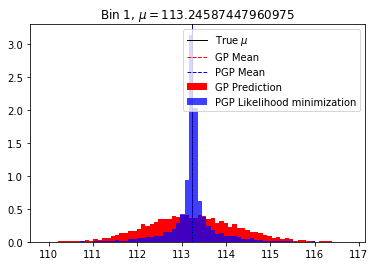

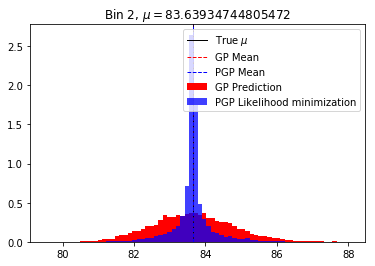

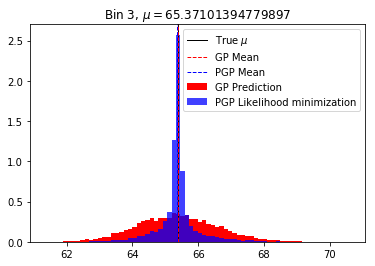

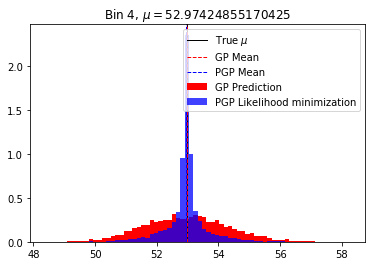

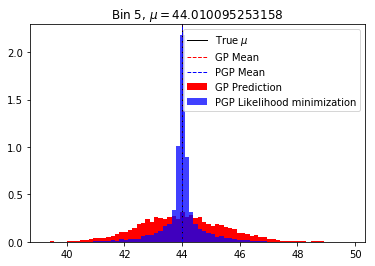

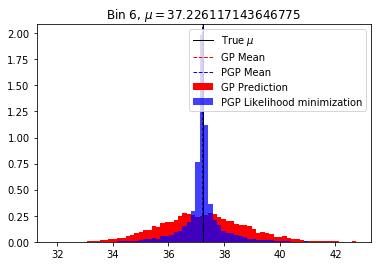

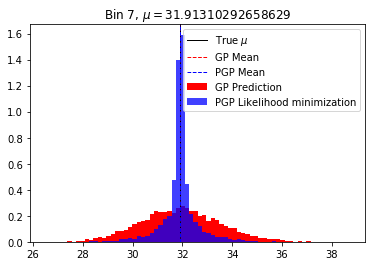

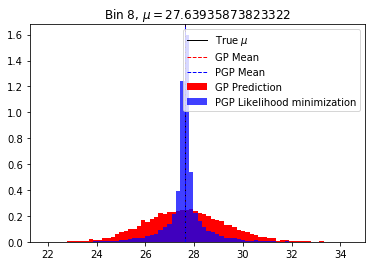

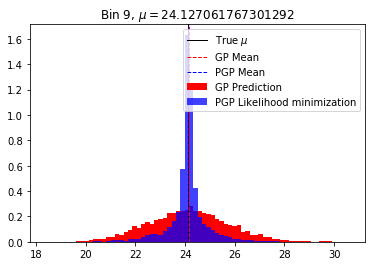

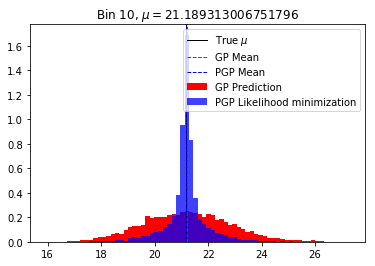

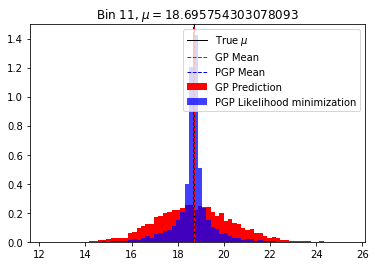

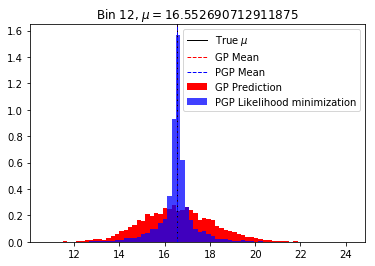

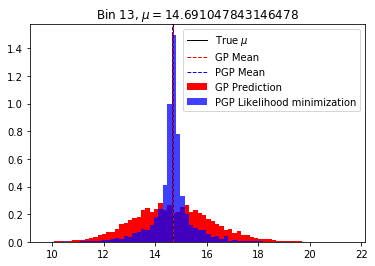

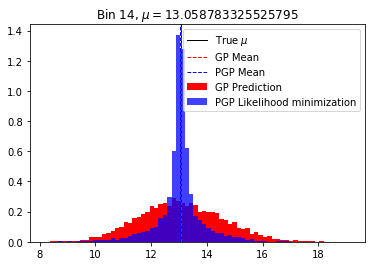

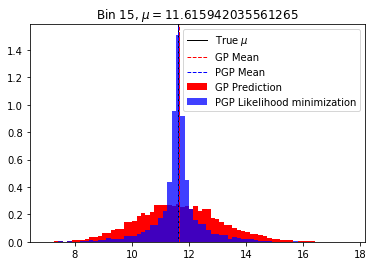

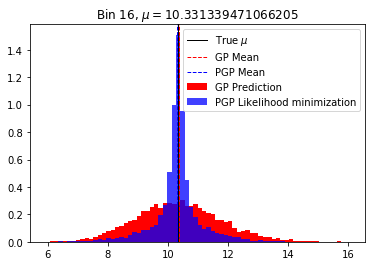

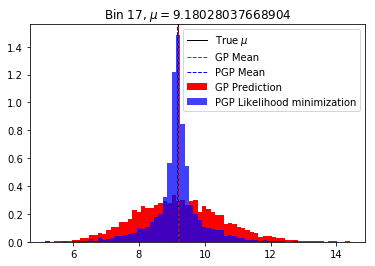

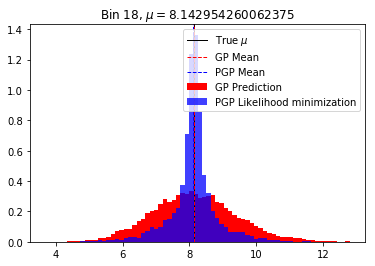

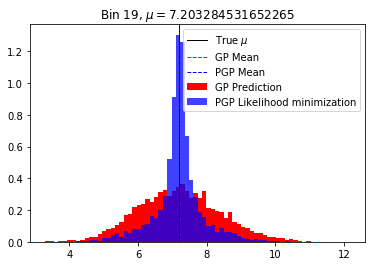

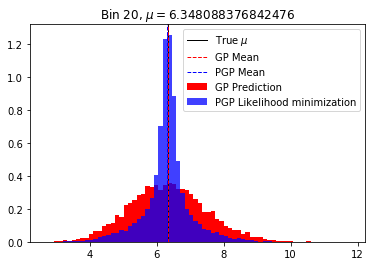

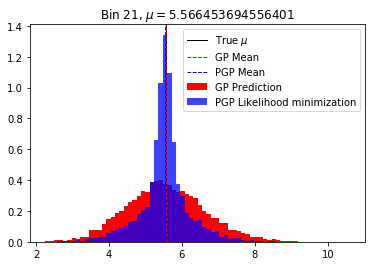

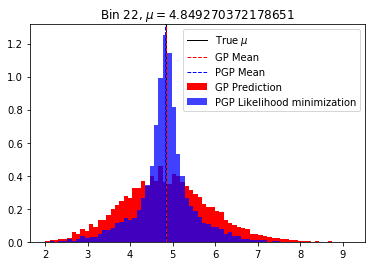

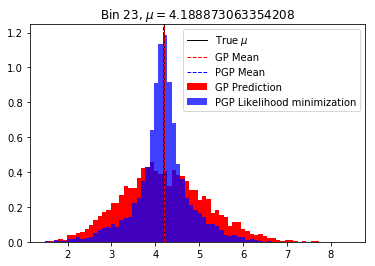

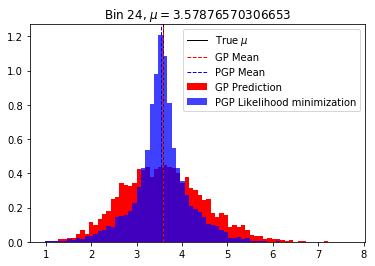

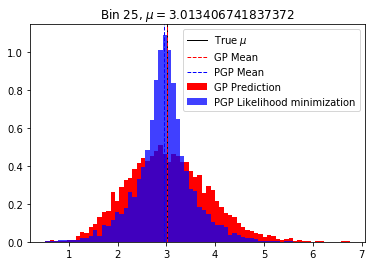

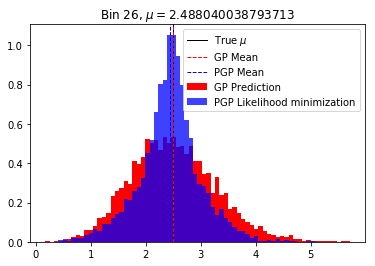

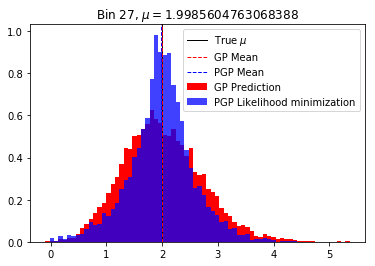

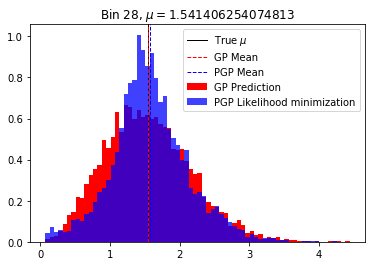

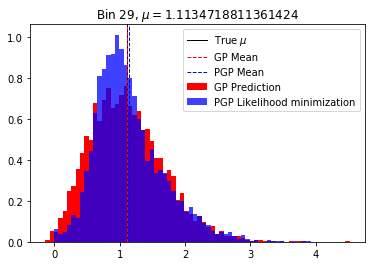

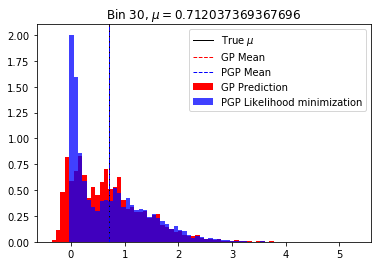

In [57]:
for bindex in range(N):
    plt.figure()
    plt.title("Bin " + str(bindex + 1) + ", $\mu = $"+str(mu_test[bindex]))
    _, bins, _ = plt.hist(np.array(mu_GP_array)[:,bindex], bins=70, normed = True, color = GP_color, label = "GP Prediction")
    plt.hist(np.array(mu_PGP_array)[:,bindex], bins=bins, normed = True, color = PGP_color, alpha = .75, label = "PGP Likelihood minimization")
    plt.axvline(mu_test[bindex], color = mu_color, linewidth=1, label = "True $\mu$")
    plt.axvline(GP_mean[bindex], color = GP_color, linestyle='dashed', linewidth=1, label = "GP Mean")
    plt.axvline(PGP_mean[bindex], color = PGP_color, linestyle='dashed', linewidth=1, label = "PGP Mean")
    #plt.axvline(y_mean[bindex], color = y_color, linestyle='dashed', linewidth=1, label = "$y$ Mean")
    plt.legend()
plt.show()

Text(0.5,1,u'Counts/Bias')

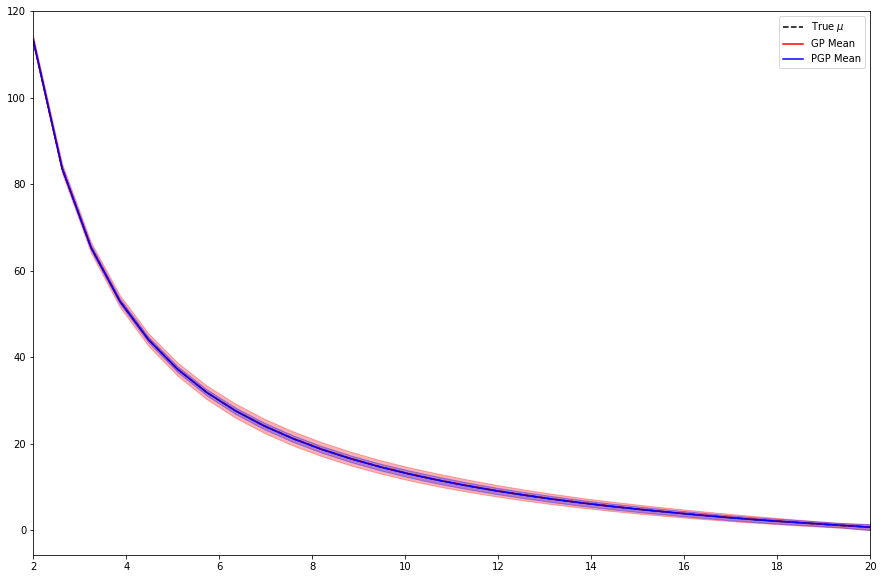

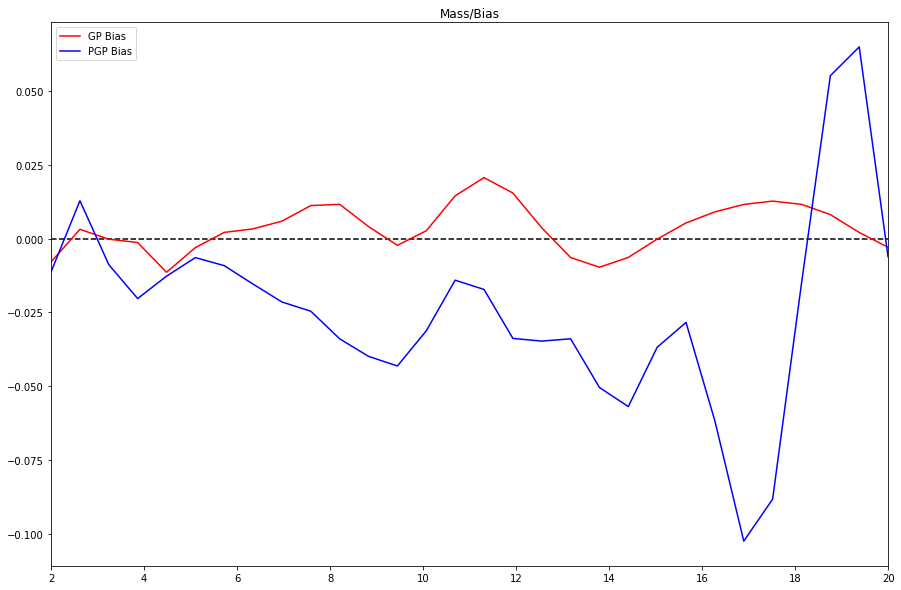

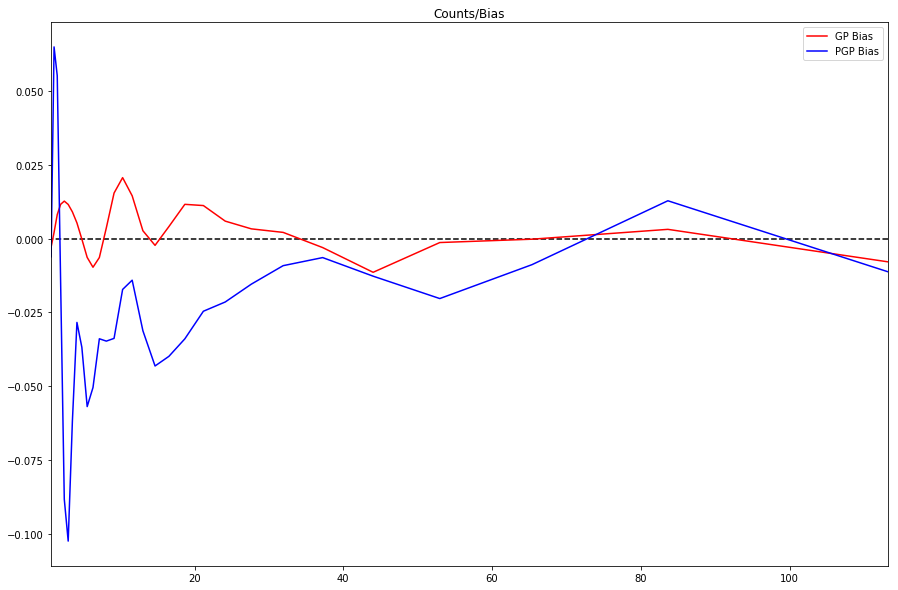

In [58]:
plt.figure(figsize=(15,10))
plt.plot(t, mu_test, 'k--', label = 'True $\mu$')
plt.fill_between(t, y_mean+y_std, y_mean-y_std, color = y_color, alpha = .3, edgecolor = 'none')
#Poisson uncertainty #plt.fill_between(t, mu_test+np.sqrt(mu_test), mu_test-np.sqrt(mu_test), color='b', alpha = .3, edgecolor = 'none')
plt.plot(t, GP_mean, GP_color, label = 'GP Mean')
plt.fill_between(t, GP_mean+GP_std, GP_mean-GP_std, color = GP_color, alpha = .3, edgecolor = 'none')
plt.plot(t, PGP_mean, PGP_color, label = 'PGP Mean')
plt.fill_between(t, PGP_mean+PGP_std, PGP_mean-PGP_std, color = PGP_color, alpha = .3, edgecolor = 'none')
plt.xlim((t[0], t[-1]))
plt.legend()


GP_bias = (GP_mean - mu_test)/GP_std
PGP_bias = (PGP_mean - mu_test)/PGP_std

plt.figure(figsize=(15,10))
plt.plot(t, np.zeros(N), 'k--')
plt.plot(t, GP_bias, GP_color, label = 'GP Bias')
plt.plot(t, PGP_bias, PGP_color, label = 'PGP Bias')
plt.xlim((t[0], t[-1]))
plt.legend()
plt.title('Mass/Bias')


plt.figure(figsize=(15,10))
plt.plot(mu_test, np.zeros(N), 'k--')
plt.plot(mu_test, GP_bias, GP_color, label = 'GP Bias')
plt.plot(mu_test, PGP_bias, PGP_color, label = 'PGP Bias')
plt.legend()
plt.xlim((mu_test[-1], mu_test[0]))
plt.title('Counts/Bias')



In [59]:
for i in range(len(mu_PGP_array)):
    print np.array(mu_PGP_array)[i,-3]

1.3971609828706357
0.7961980150598793
1.6396243040006524
2.3502068139082195
0.9787517175182329
0.8344685728175574
1.181349518428983
2.488893740161981
1.1500727390628163
1.1660728314238489
1.4673618417805034
1.1427788307426088
2.236892080429023
1.5635724058616671
1.7670085466779297
1.4558242918996644
1.532111771845889
2.8799390772254023
1.7385283493728967
1.3086380859718865
0.8056692521216318
1.4591869740530454
1.1044644742413336
1.6021174696050495
0.9347303910698931
2.8972728528643192
2.5857505712144753
3.8253816361255124
2.543542824431629
1.5306046814224445
2.0210717810779912
1.6559659375544253
0.7227824587778593
1.8877700500870804
1.4176744844532916
1.4761568467717312
1.5630072836702145
3.05860984604689
1.7703358823588005
2.4125993393166287
1.522504850715034
0.13328999723286386
3.2685368197681486
2.2256592411205363
2.065132101799541
1.7035910213433874
1.4117974303626344
2.211738233188546
2.411293777157827
2.479044648345064
2.0107312698132738
1.8139552505879493
1.979636993923255
1.494

1.7489090318503981
2.226104032125351
1.4548562520829786
1.3866118313485118
1.417104303598691
2.2781856100309783
1.543034174484223
1.5515338761171982
2.939421918095716
1.4909532974432849
1.4848284128843112
2.7452437521679807
2.672196080468544
1.0824346623172727
1.6131667160796375
1.6559418485116215
0.4672941374940066
0.292638079487837
2.245742979373569
1.312902433430606
1.1962496113706775
1.213773346354605
1.9025671230570689
0.8935864270431816
1.2808145659327885
2.5800353057027308
1.7929602760258792
2.1985002998300365
1.441704661455023
1.1933761845452355
1.2469903625593726
1.2173189464884586
1.489554413551015
1.0935708431420739
1.6771537093407942
1.5742176811645427
2.1763947240697394
1.7776310101001842
1.6303762123093994
2.0332324929318424
1.7928729824195362
1.8141595395896792
1.592985657094495
1.9331721071473407
2.7621922661346687
1.8834860238458628
1.6432475303914125
1.6417680493850053
2.1249831484602026
2.033257639631551
1.0859989174624083
1.6173634314994387
2.568604912688481
1.69258

1.8029732509440792
2.1144358920267616
1.7573623770760585
1.2366372676892095
1.3100804349709423
1.5407460365338634
1.4800067048262504
1.412659602011944
1.7184017558641758
1.5286140307599392
2.0214432608614668
2.083069204671091
2.034167929677136
2.26446487598019
1.5915152687587348
1.5553645946486807
1.7007778850378243
1.1947943270977592
1.2778236692642906
2.0665816373211543
1.4418996102043122
1.7380647646968108
1.2883515212569476
2.4381761575435412
1.9256477027487142
1.2520250318049202
2.1959295056766694
2.3468115622012293
2.394312130973256
2.1185159469279538
1.7284736372514158
1.1307961228132486
1.2152259566462074
1.1105564614699992
1.4883125542807887
1.9501964925427886
1.6691697814435749
1.4753852585497798
2.677247934051997
1.5098479443853456
1.6114156868148617
1.597647950958904
1.3648457508074732
1.6876403317084567
1.7772897194337542
2.0217975659802563
1.6650945544641915
1.3726489740622378
1.3423047818627536
1.7834692305380397
1.361674898299333
1.9648059506522995
1.4238910876296738
1.

2.2383410851491665
1.4599548805467855
1.3965978475249192
2.486740475786913
2.3033563480435215
2.683801889808786
0.8435619998680147
1.6220507759688632
2.4721020353196455
0.908717749487538
1.561347750734
1.5495646289390357
1.527156010523308
1.684932597445232
1.8627045794864017
0.835991760891075
1.190703006216156
1.0775712169819496
1.589514912588043
1.6919384279276664
1.2214764947838705
1.7852654481372887
1.3203730705747954
1.1519764720575618
2.3403507094242464
1.1127697310941262
1.8496835340258169
2.5323795351145666
1.7904394734401363
2.537082815885317
1.0449601066546073
2.3497765521604963
2.5410787050737302
1.4834158925490062
2.117895605237894
2.589974595079864
1.3127515043880498
1.1230806941544016
1.5430438683660244
1.2905859459726936
1.7376457301622723
1.8748786890474374
1.1837045449923913
1.5345642817455576
1.289007788721876
1.5201712950973967
1.8090043224730614
1.8789846813768174
1.7766802733510836
1.8373577609288978
1.5206215634800733
1.2521666564767704
2.583654960414621
2.28456510

1.0912077673922562
0.1627347419344054
1.8135636209557922
0.1929227792552247
1.5579981866793697
1.4904895289005493
2.0520324864542645
0.8125164532723321
2.1166856204867095
3.1405626790811847
0.5161801335350471
1.3693727660207433
1.5687983729017072
2.09145434311608
1.2390665777035577
1.231814577757544
1.1684209990446834
1.518285976475176
1.7676976146431944
1.0456323083868206
1.8434343584549566
0.7228817908121943
1.4930217994371808
1.2549978549522238
1.3000912042596804
1.1864255323457453
1.8573462593121792
1.056197808594322
2.022308844651328
1.717484796651205
1.4910871631506637
1.7485758959337934
1.3236169869838172
0.7893627976940697
0.655978731128795
2.7237621466239643
1.2000834501962587
1.5710005635773698
2.2446726576957445
0.9090267546496508
0.4585159191886132
2.256087652606112
0.4386327616911989
1.089585731441523
1.7500382653818793
1.1127866470848802
2.30943246951974
0.8502851850893863
0.823592073370411
1.5280641031229962
1.293110457937281
1.4122920507129049
0.32028417481450844
1.4801

1.2084172537869113
1.7737082235134252
2.369661662269724
1.9184403327906394
1.2869413181582994
1.3205278558002587
2.3649249898660742
1.3124497328321645
1.3142964931185073
1.9339247916954387
0.8771344483834431
1.8483222953826346
1.5735824265916571
1.581505006682255
0.9656471456346496
0.6269693834246113
1.9502089362887618
1.243526312850927
1.4463163048967194
1.6181509499756734
1.4525075581817044
0.9708457060914132
1.5045031259812034
1.0750310552425357
1.6425861402504118
1.4636359091293007
3.277870535265068
1.534157095548887
1.6099689438065103
1.591088468418057
3.1054972385832813
1.6920408053282787
1.2321617850493565
1.5727586496801782
1.2986833565987501
1.8528516999411992
1.64848330226768
1.8660541575101004
1.669183837999849
2.8676894488053204
1.1815462860971648
1.133572652946468
1.1435252025245797
2.437966302582948
2.217287786475134
1.2174068823346345
1.9611095913939232
1.8416937808594909
0.9919941201539259
1.4237377114597252
1.3004384382336578
1.8693386393606173
1.5661566998200427
1.517

1.4487097104518385
1.150950263002279
1.3369472235869893
1.23038017392387
1.9848219323638119
1.5339604598294097
1.3449256014231799
1.3315521820043486
1.3063794643667457
1.518473036456713
1.24803650375333
1.2389343942536275
0.549513890276888
0.8644471401161622
1.648361416811091
1.9403798271484947
1.0356117479690499
2.0055936191757833
1.3840387097522806
1.298925732996862
2.5421025917865174
1.6323123122822638
1.3954928771690263
2.125939591857332
1.9238994455533425
2.2060760272224664
1.1909444516548047
2.1645362846497225
1.413830867198215
1.2494498262469447
1.802450823469935
2.0666605585794615
1.236109551017466
1.6715646551587733
1.7027163977936655
0.2648484338292298
0.026102411902026265
1.5456653954196073
1.8612003965189077
2.838035420803254
1.3046416637866458
1.8973207689525122
1.4082361217638313
0.9338630977099142
2.091297972414436
0.7019431386756826
1.3924557029557474
1.3134937832469555
1.426605191789616
1.5395403317137613
1.5841981877381266
1.983679622269296
2.2324687464669024
0.602863

1.6112356554174874
1.1071767683592153
1.7832818993080328
1.9841513794563876
1.3800191706196954
2.17705389162567
1.7434052034138885
2.163237024025565
1.6332482274809224
1.5385854017997105
1.2179467921496607
1.8050332191456695
1.3664112842492824
1.5554673885075212
1.509112702976175
1.8020536833569616
1.6625973713335647
2.1249885487601214
1.5039183626165757
2.393702758124601
1.612052787631972
1.8788547458864722
1.8930155904886599
1.4344655658731218
1.8529530907749368
1.3404758261475869
1.1506046351401105
1.7190782341975368
1.2956471625704935
1.6720072979146254
1.6970405948826295
1.4334946735963068
0.9276723671139451
1.42735830238866
0.8537491605508885
1.652679364346848
0.4905854722179266
1.263266662816047
1.3622524814544938
1.7046360256709732
2.09982761844931
2.123155273583761
1.404631530386367
0.881579429780972
1.528747042505006
1.9678346407039424
1.7701099169721466
1.8213590656054974
1.3792700757506573
2.445140643437811
1.5389739819163395
1.0134166473820647
2.1951934196706113
1.94694420

1.5287822250184357
2.3944439329207805
1.8939265334989246
1.437349640479252
1.4965938606990776
1.4052062273381167
1.0469293063694116
1.1994046656263622
1.2284655200245993
0.9953677576815374
1.218034629161112
2.160048911796879
2.133352895025239
0.9288897434477368
0.9308771860413996
2.2365434123069603
1.467110941555752
2.5292036823130193
1.6522998978590115
1.6453764658075463
1.4446555574064983
0.6509283351518124
2.0056966650603476
1.067696726586002
0.46289733295649144
0.27454596449488355
0.5858969471901564
2.0196323641616045
1.688402996636904
1.5159386583819459
1.373696992024607
2.27261404870332
2.02996405737213
0.9313001317089538
1.3044984363515402
1.4651346745678535
1.999889572602049
1.3778083043076614
0.6292263598616771
1.7310458846997547
0.1509742845352163
1.199667894109973
2.158943290265678
0.4816360439165929
1.7141063455187477
1.980173193261878
3.0219514976428465
0.993283057794765
1.534070664465652
1.3584400740165796
0.5360711797509906
1.2702892149668499
1.4820199406387757
1.0103082

1.8872371386109177
0.9587351182101039
1.5745544853050906
1.1806439914483247
1.1234585177987517
1.442690149490217
0.9990267609333028
1.5433059047491342
1.5972832873869895
1.7236523737298544
1.9252139075107957
1.8440132497273098
1.6920259805366453
1.3192640100592792
1.0401632915579806
1.8512149738307158
1.7305348556644755
1.6081675827047086
1.4955283922995368
1.6157450018039174
2.0282855050057202
1.605143318026006
1.3999358009387408
2.5246046357622176
2.0628272753758896
1.5452461716458235
1.6363968924564245
1.1937293483948062
1.4735189500978256
1.5058957705858838
1.6606744607025086
1.708642273759087
1.883807562352254
1.2417184595522015
1.2361141004812974
0.15965597455109667
1.3925793507243875
1.148028016416757
0.6605730702595854
1.470446210120222
0.1206240970315125
1.4010084237268348
1.728161843890124
1.3129015508192576
1.5642152212700084
0.5845401171856459
1.464786216780365
1.9699083604998817
2.4199918789808357
2.5230914313091963
0.7845291928373723
2.6880168516273413
2.3332359550618107


1.3005235969500084
2.0572205047364824
1.8739608330804218
1.8344640780897057
1.671118073097334
1.9595241930262872
1.6990535680536407
2.0706801597891475
1.0018945398765513
1.0149888616106653
0.3701188769843355
1.0730369011129943
1.4625131988691644
1.0809324660063746
2.50603060907748
1.0227744871576534
2.554275977171048
1.580936635494514
1.6516327036959553
1.0822588573116423
1.1064971161779544
0.8685580220510246
2.5715368729147157
1.7928593630353975
1.2786992503891192
1.2063763809090926
2.7326758214078275
1.958063221858981
1.700164493785204
1.9415093711281068
2.591621353046335
1.6612475714394366
0.8512957225791868
2.3085348062602025
0.6538390729770271
1.5603695132121105
1.412754048596671
0.09769802983298971
1.0489413896424913
1.9019843370114868
1.267515413302517
1.7792850610590294
2.4181679511984764
1.2942935458468605
1.2201275920615255
1.7749385143144671
1.7160227378538064
0.6714726121258332
1.2245780266610162
0.6212524150865466
1.4879001305096915
1.7040042182517905
1.2055514096285103
1.

0.8042276482904742
1.0041374490516477
1.2071886439030743
2.097257465826528
1.627904077840712
2.5746474079121966
2.270400695882738
1.519331672578101
1.6024478284729011
2.2707025049383516
1.8728413614475956
2.5294902755455744
1.6677750850235
1.4302372877707366
1.9315048770766503
1.2746445499597967
1.5901011197844388
1.626332974011252
1.5550499072382233
2.056285315580231
2.1621754412287006
1.7425874518921483
1.429954717327431
0.6889063732381555
1.0995051986464743
1.178038125973057
3.1940995613535033
1.1994914251928397
1.5311270161638617
1.3272342377763209
2.666488374323819
1.0962015348259289
1.6701734880653851
1.190317603955687
1.306140139242128
1.768039101446592
0.8905606902898844
1.7753854105554905
1.3156563374226562
1.834825519093704
1.449163254801574
1.6389851588502673
1.4909202242753272
0.9880846271058227
1.2898766489984368
2.113573676574452
1.949658705416017
1.7338402832100186
1.5709390113924036
1.1562689277166593
1.1705295886867595
1.7923958158128417
1.8493349382990878
1.4726571442

2.598257734069619
1.6161293928818976
0.9666019668243183
1.0788297290874171
2.083414765888836
1.8020924188400922
2.203990397263243
0.014249332645794794
2.485999968291031
1.3928602879696477
1.8432805557149399
1.3569277669858402
1.8486319683761585
1.204317200439841
1.6286711922560746
1.6014884389405293
0.4474300613039836
1.7667235562305594
3.52310450812282
1.9582617422049746
0.7797442829833199
1.3892783512515448
1.9675811516061552
1.567458934353385
1.4142564375804432
2.123381015322464
1.194695147881129
1.0576544391867702
1.8270490705320936
1.9143818550473568
1.6572883476555709
1.9232633680350382
1.246858973403725
1.3537113675622965
1.657363810202029
1.6049650547495886
0.8926663041018785
1.2570889814833555
1.2197753505503406
1.6668113294002755
0.30466739465217296
1.5073904060442185
1.4828202924019018
2.705701075018783
0.8774441102664697
2.046904109939983
2.162363576337051
1.1949530158763015
2.86935647467575
1.9760026400628692
1.7346368904541185
2.195809951049642
2.6415808097861415
2.173337

1.2124204639003682
1.644627073226982
0.510219708289582
1.4279605335835324
1.628275644047103
2.113182072411821
1.2134793555605743
2.0352949990504436
0.41346971065613053
1.5493671409964833
1.6314921967260125
1.5757136292632268
2.3330221537723816
1.6334548331405467
1.6256787866715054
1.0278230071979313
1.0565769303079022
1.2217017110210484
0.8431683045590489
2.2976404670935953
2.2099747554455846
1.2039152836306752
2.123940220481086
1.9926639446518715
1.5917743449385822
1.3949290604448448
1.758626808216067
0.38037679553158626
1.5572632433551565
1.5797431861828564
1.5413147390324728
2.1100697477011194
1.3353767669099437
1.294074773995392
1.43975811016232
2.751202324419681
1.640466712008781
1.378941861820711
1.470618666754255
1.3501263063453814
1.069780162359237
1.7143660398067613
1.4599390477443208
1.166816365156869
1.825800299162162
1.9979862079880966
1.4176880824585902
2.654049826687605
1.3221763446790904
1.0663643377733583
1.5136572577885823
2.3736563238356343
1.3892686765279365
1.674022